# FIRE - Far-ultraviolet Irradiated Rotational Evolution model for low mass stars

## Stellar Evolution - Baraffe et al. (2015) evolutionary tracks

**Last update (Julia Roquette - 11th August 2021):** Added to github.


The package `StarEvolution.py` includes functions for reading stellar evolution models and tracks to be used in the Spin Evolution model. Currently, the package only includes the [Baraffe et al. 2015 (BHAC15)](https://ui.adsabs.harvard.edu/abs/2015A%26A...577A..42B/abstract). BHAC15 are for stars in the range 0.01 - 1.4 M$_\odot$, but for this packagem I am only using tracks down to 0.075 M$_\odot$. The models were retreived from [Isabelle's website](http://perso.ens-lyon.fr/isabelle.baraffe/BHAC15dir/BHAC15_tracks+structure). The tracks are located at `/Users/jroquette/work/prog/python/fire/data/stellar_model/BHAC15`. Some of the tracks are calculated at different timesteps, hence I pre-processed the tracks in order to resample them to the same timesteps. The original mass-tracks are names `#p###Msu_masstrack.txt` and the resampled ones `#p###Msu_masstrack_res.txt`

This part of the code initialises the `class` by reading all the files with mass tracks in the mass range 0.075 -- 1.4 M$_\odot$. This initialisation step significantly improves the time for running the code multiple times when simulating populations of stars.

```python
class BHAC15_MassTrack:
    """
    Loads Baraffe et al. (2015, BHAC15) Mass Tracks
    
    Tracks are for Solar Metalicity stars.
    source: http://perso.ens-lyon.fr/isabelle.baraffe/BHAC15dir/
    
    ------------------------------------------------------------------------
    Version date 13th July 2021
    
    Usage:

        To load the grid:
            
            grid = BHAC15_MassTrack() 
        
        This will return the object:
            
            grid.BHAC15
            
        which contains the whole grid. Parameter available are detailed in [1]
        To get mass tracks for a specific mass (after loading the grid!):
            
        grid.getMassTrack(mass)
        
        this will load grid.Params for the basic Params:
            
            grid.Mass = mass in Msun
            grid.Teff = effective temperature in K 
            grid.Age = age in years
            grid.R = Radius in Rsun
            grid.k2rad = radiative gyration radius
            grid.k2conv = convective gyration radius
            grid.k2_2 = gyration radius - see note [2]
            grid.I = Momentum of Inertia (Isun) see note [2]

        If full=True, it will load the remaining parameters available with 
        the BHAC15 grid:
            
                grid.Lum = Luminosity in Lsun
                grid.logg = surface gravity (logg)
                grid.log_Li = Li abundance
                grid.Tcentral = central temperature in K
                grid.Rhocentral = central density in gr/cc
                grid.Mrad = radiative core mass in Msun
                grid.Rrad =  radiative core in Rsun

    ------------------------------------------------------------------------
    
    [1] From BHAC15 Notes:
    BHAC15 tracks and internal structure for brown dwarfs and low mass star 
    (0.075 Msun to 1.4 Msun)

    M/Ms:  mass of the star in units of solar mass
    log t: age of the star (in yr)
    Teff: effective temperature (in K)
    L/Ls: log luminosity in units of solar luminosity 
          (value used Ls=3.839d+33)
    g: log g  (surface gravity)
    R/Rs : radius of the star in units of solar radius    
           (value used Rs=6.96d10)
    log(Li/Li0): log of the ratio of surface lithium abundance to initial 
                 abundance
    log Tc : log of central temprature
    log ROc: log of central density (in gr/cc)
    Mrad: mass of radiative core (in solar mass)
    Rrad: radius of radiatif core (in solar radius)
    k2conv: convective gyration radius
    k2rad: radiative gyration radius

    ------------------
    
    [2] NOTE: Adopted convention to calculate the gyration radii:

    k2conv=[ I/(R**2 * Mstar) ]**(1/2)

    with I the moment of inertia defined here by :

    I = 2/3 integral(r**2 * dm)
    with the integral over the mass of the convective region

    Same for k2rad, corresponding to the radiative zone.

    Example: To calculate the moment of inertia with the definition
    above for a 1 Msun star at t = 4.6 Gyr, the table gives

    k2conv= 8.993E-02
    k2rad= 2.519E-01

    k2**2 = k2conv**2 + k2rad**2 ~ 0.071 
    (which is the typical value found for the Sun)

    and the moment of inertia is:
     ===> I = k2**2 * Mstar * R**2

    END OF NOTE
    
    ------------------------------------------------------------------------

    '*_res files are based on the original grid, but were resampled to 
    guarantee a regular timesampling across different mass tracks
    
    
    """

    def __init__(self, full=False):
        import os
        datadir = os.path.join(os.path.dirname(os.path.abspath(__file__)),
                           'data/stellar_model/BHAC15/')
        self.masses = np.array([0.075, 0.08, 0.09, 0.1, 0.2, 0.3, 0.4, 0.5, 
                                0.6, 0.7, 0.8, 0.9, 1.0, 1.1, 1.2, 1.3,1.4])
        self.BHAC15 = {}
        for key in ['M_Ms', 'log_t_yr', 'Teff',  'R_Rs', 'I_Is', 'k2conv', 
                    'k2rad']:
            self.BHAC15[key] = [] 
        if bool(full):
            for key in ['L_Ls', 'g', 'Log_Li_Li0', 'logTc', 'logROc', 'Mrad',
                         'Rrad']:
                self.BHAC15[key] = [] 
        for mass in self.masses:
            filename = '{:5.3f}'.format(mass)[0] + 'p' 
            filename += '{:5.3f}'.format(mass)[2:] + 'Msu_masstrack_res.txt'
            data = Table.read(datadir + filename, format='ascii')   
            for key in ['M_Ms', 'log_t_yr', 'Teff',  'R_Rs', 'k2conv', 
                        'k2rad']:
                self.BHAC15[key].extend(data[key])
            if bool(full):
                for key in ['L_Ls', 'g', 'Log_Li_Li0', 'logTc', 'logROc', 
                            'Mrad', 'Rrad']:
                    self.BHAC15[key].extend(data[key])
            self.BHAC15['I_Is'].extend((data['k2conv']**2 + data['k2rad']**2)*
                                       data['M_Ms']*data['R_Rs']**2)
        valid=np.isfinite(self.BHAC15['M_Ms'])
        for key in self.BHAC15.keys():
            self.BHAC15[key]=np.array(self.BHAC15[key])[valid]
```




This second part loads the mass-track for a given mass. The keyword `full` enables choosing between loading only stellar parameters used in the spin evolution model or opening all the parameters available.

```python
    def getMassTrack(self, mass, full=False):
        if mass in self.masses:
            select_mass = (self.BHAC15['M_Ms'] == mass)
            self.Teff = self.BHAC15['Teff'][select_mass]
            self.Mass = self.BHAC15['M_Ms'][select_mass]
            self.Age = 10**self.BHAC15['log_t_yr'][select_mass]
            self.R = self.BHAC15['R_Rs'][select_mass]
            self.I = self.BHAC15['I_Is'][select_mass]
            if bool(full):
                self.log_Li = self.BHAC15['Log_Li_Li0'][select_mass]
                self.Tcentral = 10**self.BHAC15['logTc'][select_mass]
                self.Rhocentral = 10**self.BHAC15['logROc'][select_mass]
                self.Mrad = self.BHAC15['Mrad'][select_mass]
                self.Rrad = self.BHAC15['Rrad'][select_mass]   
                self.Lum = self.BHAC15['L_Ls'][select_mass]
                self.logg = self.BHAC15['g'][select_mass]  
                self.k2conv = self.BHAC15['k2conv'][select_mass]
                self.k2rad = self.BHAC15['k2rad'][select_mass]    
                self.k2_2 = self.BHAC15['k2rad']**2 + self.BHAC15['k2conv']**2
        elif (mass < 0.075) or (mass > 1.4):
             print('outside mass range')
        else:
            i = np.argsort(abs(self.masses - mass))[0]
            if self.masses[i] > mass:
                mass_b = self.masses[i]
                mass_a = self.masses[i - 1]
            else:
                mass_a = self.masses[i]
                mass_b = self.masses[i + 1]
            x = [mass_a, mass_b]
            select_a = (self.BHAC15['M_Ms'] == mass_a)
            select_b = (self.BHAC15['M_Ms'] == mass_b)
            def interpolate(key, select_a = select_a, select_b = select_b):
                return np.array([np.interp(mass, x, y) for y in 
                                 list(zip(self.BHAC15[key][select_a], 
                                          self.BHAC15[key][select_b]))])
            self.Mass = mass
            self.Teff = interpolate('Teff')
            self.Age = 10**interpolate('log_t_yr')
            self.R = interpolate('R_Rs')
            self.k2rad = interpolate('k2rad')
            self.k2conv = interpolate('k2conv')     
            self.k2_2=self.k2conv**2+self.k2rad**2
            self.I=self.k2_2*self.Mass*(self.R**2)            
            if bool(full):                
                self.Lum = interpolate('L_Ls')
                self.logg = interpolate('g')         
                self.log_Li = interpolate('Log_Li_Li0')
                self.Tcentral = 10**interpolate('logTc')
                self.Rhocentral = 10**interpolate('logROc')
                self.Mrad = interpolate('Mrad')
                self.Rrad = interpolate('Rrad')
```                

**Momentum of inertia**:

$I=\int \rho dV$

## Visualisation of stellar parameters as a function of age.

In [1]:
import numpy as np
import astropy.units as u
import matplotlib.pyplot as plt
from FIREstars.StarEvolution import BHAC15_MassTrack 

In [2]:
StarModel = BHAC15_MassTrack()

In [3]:
masses = [1.3, 1.2, 1.1, 1.2, 1., 0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.25, 
        0.2, 0.1]
MT = []
for m in masses:
    StarModel = BHAC15_MassTrack(full=True)
    StarModel.getMassTrack(m)
    MT.append(StarModel)

In [4]:
MT[0].Mass[0]

1.3

This shows $I_*$ as a function of age. Note that for masses below 0.2 M$_\odot$ $I_*$ remains almost constant few Myr. 

[Text(1, 0, '1'),
 Text(10, 0, '10'),
 Text(100, 0, '100'),
 Text(1000, 0, '1000'),
 Text(10000, 0, '10000')]

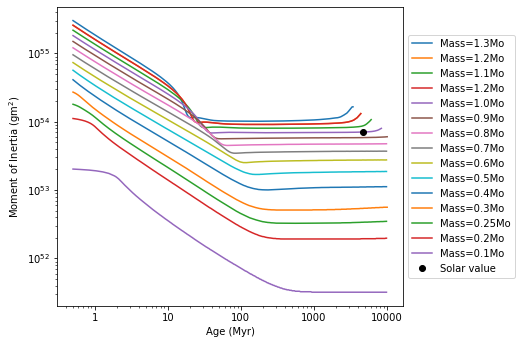

In [5]:
fig, ax = plt.subplots(1, 1, figsize=(8, 5))
plt.subplots_adjust(left=0.15, right=0.75, bottom=0.12, top=0.95)
plt.subplots_adjust(wspace=0., hspace=0)

for i, mt in enumerate(MT):
    ax.plot(mt.Age/1e6, mt.I*StarModel.M_o*StarModel.R_o**2, 
            label='Mass=' + str(masses[i]) + 'Mo')
ax.plot(4.6e3, StarModel.I_o, 'ko', label='Solar value')
ax.set_xlabel('Age (Myr)')
ax.set_ylabel(r'Moment of Inertia (gm$^2$)')
ax.set_xscale("log")
ax.set_yscale("log")
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.set_xticks([1, 10, 100, 1000, 10000])
ax.set_xticklabels([1, 10, 100, 1000, 10000])

This gives us a notion of the typical variation of $I_*$ between two consecutive timesteps in the Baraffe models.

[Text(1, 0, '1'),
 Text(10, 0, '10'),
 Text(100, 0, '100'),
 Text(1000, 0, '1000'),
 Text(10000, 0, '10000')]

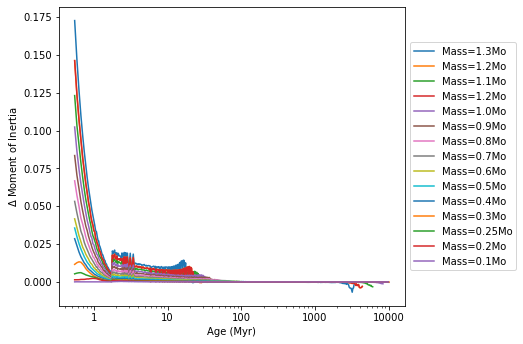

In [6]:
fig, ax = plt.subplots(1, 1, figsize=(8, 5))
plt.subplots_adjust(left=0.15, right=0.75, bottom=0.12, top=0.95)
plt.subplots_adjust(wspace=0., hspace=0)

for i, mt in enumerate(MT):
    ax.plot(mt.Age[1:]/1e6, mt.I[:-1] - mt.I[1:], 
            label='Mass='+str(masses[i]) + 'Mo')    
ax.set_xlabel('Age (Myr)')
ax.set_ylabel(r'$\Delta$ Moment of Inertia')
ax.set_xscale("log")
#ax.set_yscale("log")
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.set_xticks([1, 10, 100, 1000, 10000])
ax.set_xticklabels([1, 10, 100, 1000, 10000])

This gives us a notion of the size of the timesteps in the Baraffe models. Note that I used linear-interpolation to resample all the mass tracks and force them to have the same time steps.

[Text(1, 0, '1'),
 Text(10, 0, '10'),
 Text(100, 0, '100'),
 Text(1000, 0, '1000'),
 Text(10000, 0, '10000')]

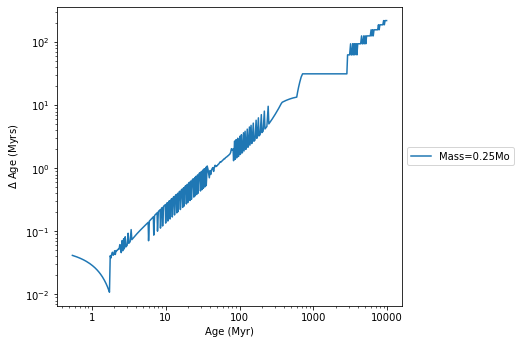

In [7]:
fig, ax = plt.subplots(1, 1, figsize=(8, 5))
plt.subplots_adjust(left=0.15, right=0.75, bottom=0.12, top=0.95)
plt.subplots_adjust(wspace=0., hspace=0)

i=-3
mt = MT[i]
ax.plot(mt.Age[1:]/1e6, mt.Age[1:]/1e6 - mt.Age[:-1]/1e6, '-', 
        label='Mass=' + str(masses[i]) + 'Mo')

ax.set_xlabel('Age (Myr)')
ax.set_ylabel(r'$\Delta$ Age (Myrs)')
ax.set_xscale("log")
ax.set_yscale("log")
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.set_xticks([1, 10, 100, 1000, 10000])
ax.set_xticklabels([1, 10, 100, 1000, 10000])

This shows the variation of Effective Temperature as a function of age. Note that the solar value, 5778 K, does not exactly match the Baraffe model for 1M$\odot$. This is because the Baraffe 2015 models **are not** calibrated to exactly match Sun. Because of that, I re-estimated $\tau_{cz\odot}$ in the spin evolution model, in order to correspond to the temperature of a star of 1M$\odot$ at the age of the Sun in the Baraffe+2015 models. 

[Text(1, 0, '1'),
 Text(10, 0, '10'),
 Text(100, 0, '100'),
 Text(1000, 0, '1000'),
 Text(10000, 0, '10000')]

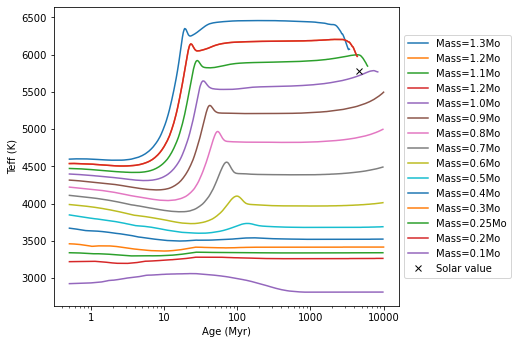

In [8]:
fig, ax = plt.subplots(1, 1, figsize=(8, 5))
plt.subplots_adjust(left=0.15, right=0.75, bottom=0.12, top=0.95)
plt.subplots_adjust(wspace=0., hspace=0)

for i, mt in enumerate(MT):
    ax.plot(mt.Age/1e6, mt.Teff, label='Mass=' + str(masses[i]) + 'Mo')
ax.plot(4.6e3, 5778, 'kx', label='Solar value')
ax.set_xlabel('Age (Myr)')
ax.set_ylabel('Teff (K)')
ax.set_xscale("log")
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.set_xticks([1, 10, 100, 1000, 10000])
ax.set_xticklabels([1, 10, 100, 1000, 10000])

Convective turnover time, $\tau_{cz}$ are estimated in `SpinEvolution.py` using [Cranmer&Saar (2011)](https://ui.adsabs.harvard.edu/abs/2011ApJ...741...54C/abstract) equation (36):

$\tau_{cz}=314.24\exp\Bigg[-\Big(\frac{T_{eff}}{1952.5 K}\Big)-\Big(\frac{T_{eff}}{6250K}\Big)^{18}\Bigg] + 0.002$.

For plotting reason, this can be quickly implemented as:

In [9]:
def tau_cz_CS11(T):
    """
    Derives the convective turnover timescale as in Cranmer & Saar 2011
    """
    return (314.24*np.exp( -(T/1952.5) - (T/6250)**18)+0.002) << u.d

Note that this function is formaly implementer in the code as part of `SpinEvolution.py`.

In [10]:
print('convective turnover timescale for a {0} K stars {1}'.format(5700, tau_cz_CS11(5700)))

convective turnover timescale for a 5700 K stars 14.019653874029629 d


In [11]:
print('convective turnover timescale for a {0} K stars {1}'.format(2930, tau_cz_CS11(2930)))

convective turnover timescale for a 2930 K stars 70.07346320246441 d


[Text(1, 0, '1'),
 Text(10, 0, '10'),
 Text(100, 0, '100'),
 Text(1000, 0, '1000'),
 Text(10000, 0, '10000')]

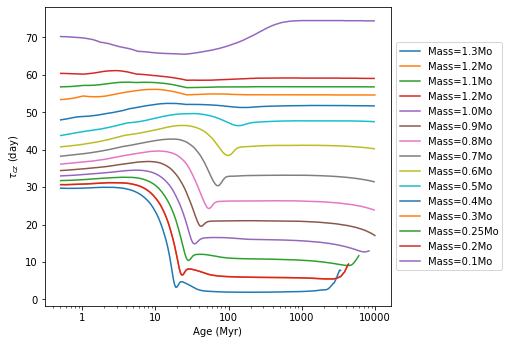

In [12]:
fig, ax = plt.subplots(1, 1, figsize=(8, 5))
plt.subplots_adjust(left=0.15, right=0.75, bottom=0.12, top=0.95)
plt.subplots_adjust(wspace=0., hspace=0)

for i, mt in enumerate(MT):
    ax.plot(mt.Age/1e6, tau_cz_CS11(mt.Teff), label='Mass=' + str(masses[i]) + 'Mo')
ax.set_xlabel('Age (Myr)')
ax.set_ylabel(r'$\tau_{cz}$ (day)')
ax.set_xscale("log")
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.set_xticks([1, 10, 100, 1000, 10000])
ax.set_xticklabels([1, 10, 100, 1000, 10000])

Radius as a function of time:

[Text(1, 0, '1'),
 Text(10, 0, '10'),
 Text(100, 0, '100'),
 Text(1000, 0, '1000'),
 Text(10000, 0, '10000')]

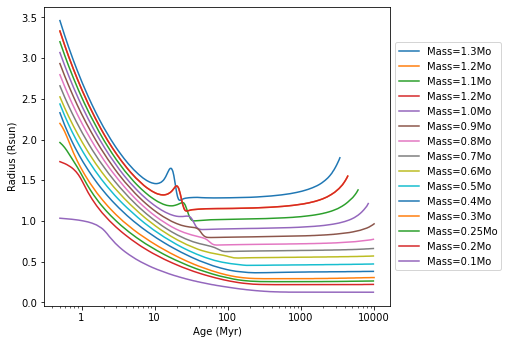

In [13]:
fig, ax = plt.subplots(1, 1, figsize=(8, 5))
plt.subplots_adjust(left=0.15, right=0.75, bottom=0.12, top=0.95)
plt.subplots_adjust(wspace=0., hspace=0)

for i, mt in enumerate(MT):
    ax.plot(mt.Age/1e6, mt.R, label='Mass=' + str(masses[i]) + 'Mo')

ax.set_xlabel('Age (Myr)')
ax.set_ylabel(r'Radius (Rsun)')
ax.set_xscale("log")
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.set_xticks([1, 10, 100, 1000, 10000])
ax.set_xticklabels([1, 10, 100, 1000, 10000])

Radiative core radius:

[Text(1, 0, '1'),
 Text(10, 0, '10'),
 Text(100, 0, '100'),
 Text(1000, 0, '1000'),
 Text(10000, 0, '10000')]

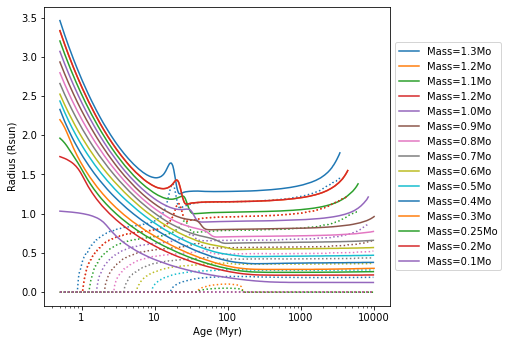

In [18]:
fig, ax = plt.subplots(1, 1, figsize=(8, 5))
plt.subplots_adjust(left=0.15, right=0.75, bottom=0.12, top=0.95)
plt.subplots_adjust(wspace=0., hspace=0)

for i, mt in enumerate(MT):
    a = ax.plot(mt.Age/1e6, mt.R, label='Mass=' + str(masses[i]) + 'Mo')
    ax.plot(mt.Age/1e6, mt.Rrad, ':', color=a[-1].get_color())
ax.set_xlabel('Age (Myr)')
ax.set_ylabel(r'Radius (Rsun)')
ax.set_xscale("log")
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.set_xticks([1, 10, 100, 1000, 10000])
ax.set_xticklabels([1, 10, 100, 1000, 10000])

Radiative Core mass:

[Text(1, 0, '1'),
 Text(10, 0, '10'),
 Text(100, 0, '100'),
 Text(1000, 0, '1000'),
 Text(10000, 0, '10000')]

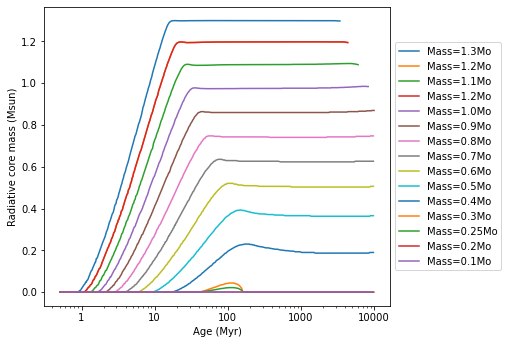

In [22]:
fig, ax = plt.subplots(1, 1, figsize=(8, 5))
plt.subplots_adjust(left=0.15, right=0.75, bottom=0.12, top=0.95)
plt.subplots_adjust(wspace=0., hspace=0)

for i, mt in enumerate(MT):
    a = ax.plot(mt.Age/1e6, mt.Mrad, label='Mass=' + str(masses[i]) + 'Mo')
ax.set_xlabel('Age (Myr)')
ax.set_ylabel(r'Radiative core mass (Msun)')
ax.set_xscale("log")
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.set_xticks([1, 10, 100, 1000, 10000])
ax.set_xticklabels([1, 10, 100, 1000, 10000])

[Text(1, 0, '1'),
 Text(10, 0, '10'),
 Text(100, 0, '100'),
 Text(1000, 0, '1000'),
 Text(10000, 0, '10000')]

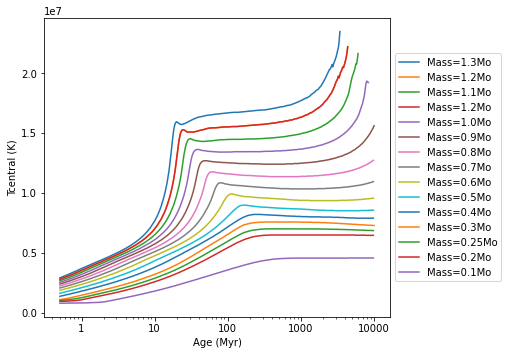

In [26]:
fig, ax = plt.subplots(1, 1, figsize=(8, 5))
plt.subplots_adjust(left=0.15, right=0.75, bottom=0.12, top=0.95)
plt.subplots_adjust(wspace=0., hspace=0)

for i, mt in enumerate(MT):
    a = ax.plot(mt.Age/1e6, mt.Tcentral, label='Mass=' + str(masses[i]) + 'Mo')
ax.set_xlabel('Age (Myr)')
ax.set_ylabel(r'Tcentral (K)')
ax.set_xscale("log")
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.set_xticks([1, 10, 100, 1000, 10000])
ax.set_xticklabels([1, 10, 100, 1000, 10000])